### 메모리 네트워크
메모리 네트워크 구조             
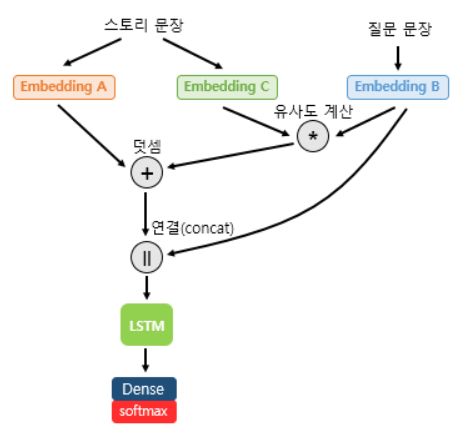
어텐션 메커니즘의 의도를 가짐(스토리 문장: value와 key, 질문 문장: query)

### 메모리 네트워크를 이용한 Babi QA 데이터셋 실습
#### 데이터셋 형태         
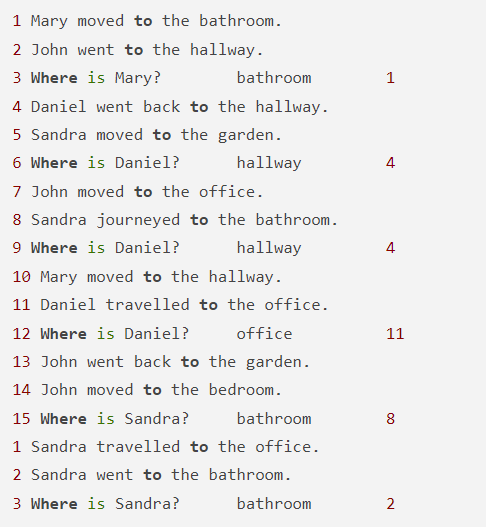
- ID가 1번으로 돌아가기 전까지가 하나의 스토리
- 질문 문장 형태: ID question[tab]answer[tab]supporting_fact ID.
- supporting fact: 실제 정답이 주어진 스토리 중 몇번째 id 문장에 있었는지 나타냄(훈련 단계에서는 사용 x)

In [1]:
from tensorflow.keras.utils import get_file
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np
import tarfile
from nltk import FreqDist
from functools import reduce
import os
import re
import matplotlib.pyplot as plt

In [2]:
# 데이터 다운로드
path = get_file('babi-tasks-v1-2.tar.gz', origin='https://s3.amazonaws.com/text-datasets/'
                'babi_tasks_1-20_v1-2.tar.gz')

11745123/11745123 [==============================] - 13s 1us/step


In [3]:
# 압축 풀기
with tarfile.open(path) as tar:
    tar.extractall()
    tar.close()

DATA_DIR = 'tasks_1-20_v1-2/en-10k'
TRAIN_FILE = os.path.join(DATA_DIR, "qa1_single-supporting-fact_train.txt")
TEST_FILE = os.path.join(DATA_DIR, "qa1_single-supporting-fact_test.txt")

In [4]:
# train 데이터 20개 라인 출력
i = 0
lines = open(TRAIN_FILE , "rb")     # rb: byte 형식으로 읽어오기
for line in lines:
    line = line.decode("utf-8").strip()
    # lno, text = line.split(" ", 1) # ID와 TEXT 분리
    i = i + 1
    print(line)
    if i == 20:
        break

1 Mary moved to the bathroom.
2 John went to the hallway.
3 Where is Mary? 	bathroom	1
4 Daniel went back to the hallway.
5 Sandra moved to the garden.
6 Where is Daniel? 	hallway	4
7 John moved to the office.
8 Sandra journeyed to the bathroom.
9 Where is Daniel? 	hallway	4
10 Mary moved to the hallway.
11 Daniel travelled to the office.
12 Where is Daniel? 	office	11
13 John went back to the garden.
14 John moved to the bedroom.
15 Where is Sandra? 	bathroom	8
1 Sandra travelled to the office.
2 Sandra went to the bathroom.
3 Where is Sandra? 	bathroom	2
4 Mary went to the bedroom.
5 Daniel moved to the hallway.


#### 전처리 : 스토리, 질문, 답변을 모두 별도로 저장

In [6]:
def read_data(dir):
    stories, questions, answers = [], [], [] # 각각 스토리, 질문, 답변을 저장할 예정
    story_temp = [] # 현재 시점의 스토리 임시 저장
    lines = open(dir, "rb")

    for line in lines:
        line = line.decode("utf-8") # b' 제거
        line = line.strip() # '\n' 제거
        idx, text = line.split(" ", 1) # 맨 앞에 있는 id number 분리
        # 여기까지는 모든 줄에 적용되는 전처리

        if int(idx) == 1:
            story_temp = []

        if "\t" in text: # 현재 읽는 줄이 질문 (tab) 답변 (tab)인 경우
            question, answer, _ = text.split("\t") # 질문과 답변을 각각 저장
            stories.append([x for x in story_temp if x]) # 지금까지의 누적 스토리를 스토리에 저장
            questions.append(question)
            answers.append(answer)

        else: # 현재 읽는 줄이 스토리인 경우
            story_temp.append(text) # 임시 저장

    lines.close()
    return stories, questions, answers

In [7]:
# 스토리, 질문, 답변을 한꺼번에 저장
train_data = read_data(TRAIN_FILE)
test_data = read_data(TEST_FILE)

In [9]:
# 스토리, 질문, 답변을 각각 따로 저장
train_stories, train_questions, train_answers = read_data(TRAIN_FILE)
test_stories, test_questions, test_answers = read_data(TEST_FILE)

In [10]:
print('훈련용 스토리의 개수 :', len(train_stories))
print('훈련용 질문의 개수 :',len(train_questions))
print('훈련용 답변의 개수 :',len(train_answers))
print('테스트용 스토리의 개수 :',len(test_stories))
print('테스트용 질문의 개수 :',len(test_questions))
print('테스트용 답변의 개수 :',len(test_answers))

훈련용 스토리의 개수 : 10000
훈련용 질문의 개수 : 10000
훈련용 답변의 개수 : 10000
테스트용 스토리의 개수 : 1000
테스트용 질문의 개수 : 1000
테스트용 답변의 개수 : 1000


In [18]:
train_stories[4950]

['Sandra went to the office.', 'Sandra moved to the hallway.']

In [19]:
train_questions[4950]

'Where is Sandra? '

In [20]:
train_answers[4950]

'hallway'

In [26]:
train_stories[4950][0] + train_stories[4950][1]

'Sandra went to the office.Sandra moved to the hallway.'

In [27]:
# 전처리 함수
def tokenize(sent):
    return [ x.strip() for x in re.split('(\W+)', sent) if x and x.strip()]
    # \W: 영어나 숫자가 아닌 문자를 뜻함 -> [^a-zA-Z0-9]
    # + : 한번 이상 반복

def preprocess_data(train_data, test_data):
    counter = FreqDist()

    # 두 문장의 story를 하나의 문장으로 통합하는 함수
    # reduce: data 안에 있는 값들을 두개(x, y)씩 꺼내오는데, 이전 게산의 결과를 누적으로 다음 x로 활용
    flatten = lambda data: reduce(lambda x, y: x + y, data) # 스토리 내 텍스트들이 하나의 문자열로 이어짐

    # 각 샘플의 길이를 저장하는 리스트
    story_len = []
    question_len = []

    for stories, questions, answers in [train_data, test_data]:
        for story in stories:
            stories = tokenize(flatten(story)) # 스토리의 문장들을 펼친 후 토큰화
            story_len.append(len(stories)) # 각 story의 길이 저장
            for word in stories: # 단어 집합에 단어 추가
                counter[word] += 1
        for question in questions:
            question = tokenize(question)
            question_len.append(len(question))
            for word in question:
                counter[word] += 1
        for answer in answers:
            answer = tokenize(answer)
            for word in answer:
                counter[word] += 1

    # 단어 집합 생성
    word2idx = {word : (idx + 1) for idx, (word, _) in enumerate(counter.most_common())}
    idx2word = {idx : word for word, idx in word2idx.items()}

    # 가장 긴 샘플의 길이
    story_max_len = np.max(story_len)
    question_max_len = np.max(question_len)

    return word2idx, idx2word, story_max_len, question_max_len

In [28]:
word2idx, idx2word, story_max_len, question_max_len = preprocess_data(train_data, test_data)

In [29]:
print(word2idx)

{'to': 1, 'the': 2, '.': 3, 'went': 4, 'Sandra': 5, 'John': 6, 'Daniel': 7, 'Mary': 8, 'travelled': 9, 'journeyed': 10, 'back': 11, 'bathroom': 12, 'garden': 13, 'hallway': 14, 'moved': 15, 'office': 16, 'kitchen': 17, 'bedroom': 18, 'Where': 19, 'is': 20, '?': 21}


In [31]:
print('스토리의 최대 길이 :',story_max_len)
print('질문의 최대 길이 :',question_max_len)

스토리의 최대 길이 : 68
질문의 최대 길이 : 4


In [32]:
vocab_size = len(word2idx) + 1

In [33]:
def vectorize(data, word2idx, story_maxlen, question_maxlen):
    Xs, Xq, Y = [], [], []
    flatten = lambda data: reduce(lambda x, y: x + y, data)

    stories, questions, answers = data
    for story, question, answer in zip(stories, questions, answers):
        xs = [word2idx[w] for w in tokenize(flatten(story))]   # 정수 인코딩
        xq = [word2idx[w] for w in tokenize(question)]
        Xs.append(xs)
        Xq.append(xq)
        Y.append(word2idx[answer])

        # 스토리와 질문은 각각의 최대 길이로 패딩
        # 정답은 원-핫 인코딩
    return pad_sequences(Xs, maxlen=story_maxlen),\
           pad_sequences(Xq, maxlen=question_maxlen),\
           to_categorical(Y, num_classes=len(word2idx) + 1)

In [34]:
Xstrain, Xqtrain, Ytrain = vectorize(train_data, word2idx, story_max_len, question_max_len)
Xstest, Xqtest, Ytest = vectorize(test_data, word2idx, story_max_len, question_max_len)

In [35]:
Xstrain[0]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  8, 15,  1,  2, 12,  3,  6,  4,  1,  2, 14,  3])

In [37]:
print(Xstrain.shape, Xqtrain.shape, Ytrain.shape, Xstest.shape, Xqtest.shape, Ytest.shape)

(10000, 68) (10000, 4) (10000, 22) (1000, 68) (1000, 4) (1000, 22)


#### 메모리 네트워크

In [38]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Permute, dot, add, concatenate
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Activation

In [39]:
# 에포크 횟수
train_epochs = 120
# 배치 크기
batch_size = 32
# 임베딩 크기
embed_size = 50
# LSTM의 크기
lstm_size = 64
# 드롭아웃 적용 비율
dropout_rate = 0.3

In [40]:
input_sequence = Input((story_max_len,))
question = Input((question_max_len,))

print('Stories :', input_sequence)
print('Question:', question)

Stories : KerasTensor(type_spec=TensorSpec(shape=(None, 68), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
Question: KerasTensor(type_spec=TensorSpec(shape=(None, 4), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")


In [41]:
# 스토리를 위한 첫번째 임베딩. 그림에서의 Embedding A
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,
                              output_dim=embed_size))
input_encoder_m.add(Dropout(dropout_rate))
# 결과 : (samples, story_max_len, embedding_dim) / 샘플의 수, 문장의 최대 길이, 임베딩 벡터의 차원


# 스토리를 위한 두번째 임베딩. 그림에서의 Embedding C
# 임베딩 벡터의 차원을 question_max_len(질문의 최대 길이)로 한다.
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,
                              output_dim=question_max_len))
input_encoder_c.add(Dropout(dropout_rate))
# 결과 : (samples, story_max_len, question_max_len) / 샘플의 수, 문장의 최대 길이, 질문의 최대 길이(임베딩 벡터의 차원)

In [42]:
# 질문을 위한 임베딩. 그림에서의 Embedding B
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,
                               output_dim=embed_size,
                               input_length=question_max_len))
question_encoder.add(Dropout(dropout_rate))
# 결과 : (samples, question_max_len, embedding_dim) / 샘플의 수, 질문의 최대 길이, 임베딩 벡터의 차원

In [43]:
# 실질적인 임베딩 과정
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

print('Input encoded m', input_encoded_m)
print('Input encoded c', input_encoded_c)
print('Question encoded', question_encoded)

Input encoded m KerasTensor(type_spec=TensorSpec(shape=(None, 68, 50), dtype=tf.float32, name=None), name='sequential/dropout/Identity:0', description="created by layer 'sequential'")
Input encoded c KerasTensor(type_spec=TensorSpec(shape=(None, 68, 4), dtype=tf.float32, name=None), name='sequential_1/dropout_1/Identity:0', description="created by layer 'sequential_1'")
Question encoded KerasTensor(type_spec=TensorSpec(shape=(None, 4, 50), dtype=tf.float32, name=None), name='sequential_2/dropout_2/Identity:0', description="created by layer 'sequential_2'")


In [44]:
# 스토리 단어들과 질문 단어들 간의 유사도를 구하는 과정
# 유사도는 내적을 사용한다.
match = dot([input_encoded_m, question_encoded], axes=-1, normalize=False)
match = Activation('softmax')(match)
print('Match shape', match)
# 결과 : (samples, story_maxlen, question_max_len) / 샘플의 수, 문장의 최대 길이, 질문의 최대 길이

response = add([match, input_encoded_c])  # (samples, story_max_len, question_max_len)
response = Permute((2, 1))(response)  # (samples, question_max_len, story_max_len)  # permute: 차원 변경(transpose의 일반화)
print('Response shape', response)

# 질문 벡터와 답변 벡터를 연결
answer = concatenate([response, question_encoded])
print('Answer shape', answer)

answer = LSTM(lstm_size)(answer)
answer = Dropout(dropout_rate)(answer)
answer = Dense(vocab_size)(answer)
answer = Activation('softmax')(answer)

Match shape KerasTensor(type_spec=TensorSpec(shape=(None, 68, 4), dtype=tf.float32, name=None), name='activation/Softmax:0', description="created by layer 'activation'")
Response shape KerasTensor(type_spec=TensorSpec(shape=(None, 4, 68), dtype=tf.float32, name=None), name='permute/transpose:0', description="created by layer 'permute'")
Answer shape KerasTensor(type_spec=TensorSpec(shape=(None, 4, 118), dtype=tf.float32, name=None), name='concatenate/concat:0', description="created by layer 'concatenate'")


In [45]:
model = Model([input_sequence, question], answer)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['acc'])

print(model.summary())

history = model.fit([Xstrain, Xqtrain],
         Ytrain, batch_size, train_epochs,
         validation_data=([Xstest, Xqtest], Ytest))

model.save('model.h5')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 68)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 4)]          0           []                               
                                                                                                  
 sequential (Sequential)        (None, None, 50)     1100        ['input_1[0][0]']                
                                                                                                  
 sequential_2 (Sequential)      (None, 4, 50)        1100        ['input_2[0][0]']                
                                                                                              

Epoch 35/120
313/313 [==============================] - 2s 5ms/step - loss: 0.5351 - acc: 0.8127 - val_loss: 0.5231 - val_acc: 0.8200
Epoch 36/120
313/313 [==============================] - 2s 5ms/step - loss: 0.4821 - acc: 0.8318 - val_loss: 0.4682 - val_acc: 0.8330
Epoch 37/120
313/313 [==============================] - 2s 6ms/step - loss: 0.4397 - acc: 0.8406 - val_loss: 0.4085 - val_acc: 0.8520
Epoch 38/120
313/313 [==============================] - 2s 6ms/step - loss: 0.3997 - acc: 0.8547 - val_loss: 0.3877 - val_acc: 0.8550
Epoch 39/120
313/313 [==============================] - 2s 6ms/step - loss: 0.3768 - acc: 0.8649 - val_loss: 0.3767 - val_acc: 0.8550
Epoch 40/120
313/313 [==============================] - 2s 6ms/step - loss: 0.3685 - acc: 0.8662 - val_loss: 0.3617 - val_acc: 0.8620
Epoch 41/120
313/313 [==============================] - 2s 5ms/step - loss: 0.3481 - acc: 0.8716 - val_loss: 0.3607 - val_acc: 0.8640
Epoch 42/120
313/313 [==============================] - 2s 5ms

313/313 [==============================] - 2s 6ms/step - loss: 0.0362 - acc: 0.9886 - val_loss: 0.0811 - val_acc: 0.9730
Epoch 97/120
313/313 [==============================] - 2s 6ms/step - loss: 0.0395 - acc: 0.9884 - val_loss: 0.0795 - val_acc: 0.9790
Epoch 98/120
313/313 [==============================] - 2s 6ms/step - loss: 0.0385 - acc: 0.9895 - val_loss: 0.0848 - val_acc: 0.9740
Epoch 99/120
313/313 [==============================] - 2s 6ms/step - loss: 0.0387 - acc: 0.9891 - val_loss: 0.0981 - val_acc: 0.9740
Epoch 100/120
313/313 [==============================] - 2s 6ms/step - loss: 0.0324 - acc: 0.9914 - val_loss: 0.0857 - val_acc: 0.9760
Epoch 101/120
313/313 [==============================] - 2s 6ms/step - loss: 0.0376 - acc: 0.9891 - val_loss: 0.0809 - val_acc: 0.9790
Epoch 102/120
313/313 [==============================] - 2s 6ms/step - loss: 0.0396 - acc: 0.9896 - val_loss: 0.0732 - val_acc: 0.9770
Epoch 103/120
313/313 [==============================] - 2s 6ms/step - l

In [46]:
print("\n 테스트 정확도: %.4f" % (model.evaluate([Xstest, Xqtest], Ytest)[1]))

32/32 [==============================] - 0s 1ms/step - loss: 0.0696 - acc: 0.9820

 테스트 정확도: 0.9820


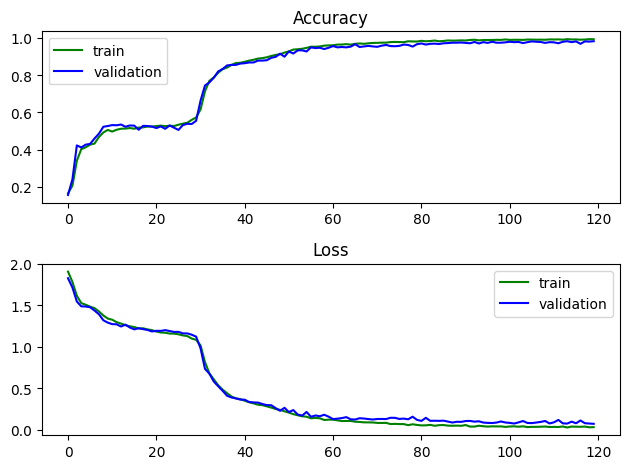

32/32 [==============================] - 0s 1ms/step


In [47]:
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="g", label="train")
plt.plot(history.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color="g", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

ytest = np.argmax(Ytest, axis=1)

Ytest_ = model.predict([Xstest, Xqtest])
ytest_ = np.argmax(Ytest_, axis=1)

In [56]:
word2idx

{'to': 1,
 'the': 2,
 '.': 3,
 'went': 4,
 'Sandra': 5,
 'John': 6,
 'Daniel': 7,
 'Mary': 8,
 'travelled': 9,
 'journeyed': 10,
 'back': 11,
 'bathroom': 12,
 'garden': 13,
 'hallway': 14,
 'moved': 15,
 'office': 16,
 'kitchen': 17,
 'bedroom': 18,
 'Where': 19,
 'is': 20,
 '?': 21}

In [57]:
ytest_[:10]

array([14, 12, 17, 14, 17, 14, 13, 14, 16, 16], dtype=int64)